<h1 style="text-align:center">An Interactive Fast Fourier Transform (FFT)</h1>
<h2 style="text-align:center">MCHE 485: Mechanical Vibrations</h2>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu\">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/</p>

This notebook will present an interactive [Fast Fourier Tranform](https://en.wikipedia.org/wiki/Fast_Fourier_transform), or FFT for a simple, term-term harmonic signal. For more infomation on the FFT, see the [Introduction to the FFT Notebook](http://nbviewer.jupyter.org/github/DocVaughan/MCHE485---Mechanical-Vibrations/blob/Spring2016/Jupyter%20Notebooks/FFT%20-%20Introduction.ipynb).

The signal that this notebook analyzing is a simple sum of three sine waves:

$ \quad f(t) = A_1 \sin{(\omega_1 t)} + A_2 \sin{(\omega_2 t)} + A_3 \sin{(\omega_3 t)} $ 

The sliders presented in the interactive portion of the notebook allow amplitudes, $A_1$, $A_2$, and $A_3$, and frequencies, $\omega_1$, $\omega_2$, and $\omega_3$, to be changed. Any time any of these parameters is changed, the plots will automatically regenerate.

The "best" way to use this notebook is to use the Cell... Run All command from the menu bar, then scroll down to the bottom of the notebook and play with the sliders.

*NOTE*: The interactive portion of this notebook will not run in the online notebook viewer, so you'll have to run it locally to play with the interactive part.

In [1]:
# Grab all of the NumPy functions with namespace (nickname) np
import numpy as np              

In [2]:
# Set up the notebook to display plots inline
%matplotlib inline

# Import the plotting functions 
import matplotlib.pyplot as plt

In [3]:
# import the IPython widgets
from ipywidgets.widgets import interact
from ipywidgets import widgets            # Widget definitions
from IPython.display import display       # Used to display widgets in the notebook

In [4]:
t = np.linspace(0, 25, 5001)   # Time, 0-25s with 5001 samples in the range

In [5]:
def plot_FFT(A1 = 1.0, f1 = 1.0, A2 = 0.5, f2 = 2.75, A3 = 1.5, f3 = 7.5):
    
    w1 = f1 * (2 * np.pi)    # frequency of first sine (rad/s)
    w2 = f2 * (2 * np.pi)   # frequency of second sine (rad/s)
    w3 = f3 * (2 * np.pi)    # frequency of third sine (rad/s)

    orig_signal = A1 * np.sin(w1 * t) + A2 * np.sin(w2 * t) + A3 * np.sin(w3 * t)
    
    # We can also use the FFT to get the natrual frequency
    freq, mag = CRAWLAB_fft(orig_signal, t, False)
    
    # Make the figure pretty, then plot the results
    #   "pretty" parameters selected based on pdf output, not screen output
    #   Many of these setting could also be made default by the .matplotlibrc file
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    plt.subplots_adjust(bottom=0.12,left=0.17,top=0.96,right=0.96)
    plt.setp(ax1.get_ymajorticklabels(),family='serif',fontsize=18)
    plt.setp(ax1.get_xmajorticklabels(),family='serif',fontsize=18)

    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax1.grid(True,linestyle=':',color='0.75')
    ax1.set_axisbelow(True)

    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    ax2.grid(True,linestyle=':',color='0.75')
    ax2.set_axisbelow(True)

    # Original Signal
    ax1.set_xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
    ax1.set_ylabel('Signal Amplitude', family='serif', fontsize=22, weight='bold', labelpad=10)

    ax1.plot(t, orig_signal, linewidth=2, linestyle='-', label=r'Original Signal')
    ax1.set_xlim(0, 5)

    # FFT
    ax2.set_xlabel('Frequency (Hz)',fontsize=22, labelpad=5)
    ax2.set_ylabel('FFT magnitude',fontsize=22, labelpad=10)

    ax2.plot(freq, mag, linewidth=2, linestyle='-', label = 'FFT')

    # Let's also annotate the plot with vertical lines at each of the frequencies in our original signal
    ax2.plot([w1 / (2 * np.pi), w1 / (2 * np.pi)], [0, 1], linewidth = 2, linestyle = '--', label = r'$\omega_1$')
    ax2.plot([w2 / (2 * np.pi), w2 / (2 * np.pi)], [0, 1], linewidth = 2, linestyle = '-.', label = r'$\omega_2$')
    ax2.plot([w3 / (2 * np.pi), w3 / (2 * np.pi)], [0, 1], linewidth = 2, linestyle = ':', label = r'$\omega_3$')

    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 1.0)

    ax2.leg = ax2.legend(loc='upper right', ncol = 2, fancybox=True)
    ltext  = ax2.leg.get_texts()
    plt.setp(ltext,family='Serif',fontsize=16)

    # Adjust the page layout filling the page using the new tight_layout command
    plt.tight_layout(pad=0.5, w_pad=5.0)



I've written a function for my lab that takes care of a lot of the boilerplate code necessary to complete and plot the FFT. The function, defined in the next cell, is named ```CRAWLAB_fft```. It relies on the ```fft``` function from the ```fftpack``` module of SciPy.

The function recenters data about zero, applies a Hanning window to the data, and selects the real-valued components returned from the SciPy ```fft``` function. If ```plotflag``` is ```True```, then it will also automatically generate the plot of the FFT magnitude. Reasons for doing these things are a bit beyond this tutorial, so, for now, you can just think of ```CRAWLAB_fft``` as implementing the FFT algorithm for you.

In [6]:
def CRAWLAB_fft(data, time, plotflag):
    ''' Function to get the FFT for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #   plotflag = will plot the FFT if nonzero
    #   
    # Output:
    #   fft_freq = an array of the freqs used in the FFT
    #   fft_mag = an array of the amplitude of the FFT at each freq in fft_freq
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    ######################################################################################
    '''
    
    from scipy.fftpack import fft
    
    # correct for any DC offset
    offset = np.mean(data) 

    # Get the sampling time
    sample_time = time[1] - time[0]
    
    # Get the length of the dataset
    n = len(data)

    # Calculate the FFT of the data, removing the offset and using a Hanning Window
    fft_mag = fft((data - offset) * np.hanning(len(data)))
    
    # Define the frequency range of the output
    fft_freq = np.linspace(0.0, 1.0 / (2.0*sample_time), int(np.ceil(n/2)))
    
    # Only return the "useful" part of the fft
    fft_mag = 2.0/n * np.abs(fft_mag[0:int(np.ceil(n/2))])
    
    # If plotflag is nonzero (True), plot the FFT before returning the magnitude and phase
    if plotflag:
        # Plot the relationshiop
        #   Many of these setting could also be made default by the .matplotlibrc file
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
        plt.setp(ax.get_ymajorticklabels(),fontsize=18)
        plt.setp(ax.get_xmajorticklabels(),fontsize=18)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.grid(True, linestyle=':', color='0.75')
        ax.set_axisbelow(True)

        plt.xlabel('Frequency (Hz)', fontsize=22, labelpad=8)
        plt.ylabel('FFT magnitude', fontsize=22, labelpad=10)
    
        plt.plot(fft_freq, fft_mag, linewidth=2, linestyle='-')
        
        # Adjust the page layout filling the page using the new tight_layout command
        plt.tight_layout(pad=0.5)
        plt.show()
    
    return fft_freq, fft_mag

Now will make the call to the interact function, setting up the ranges for each parameter. The result will be six sliders, representing the amplitude and frequency of each component of the signal. Each time one of the sliders is changed, the plot of the signal and the FFT should update.

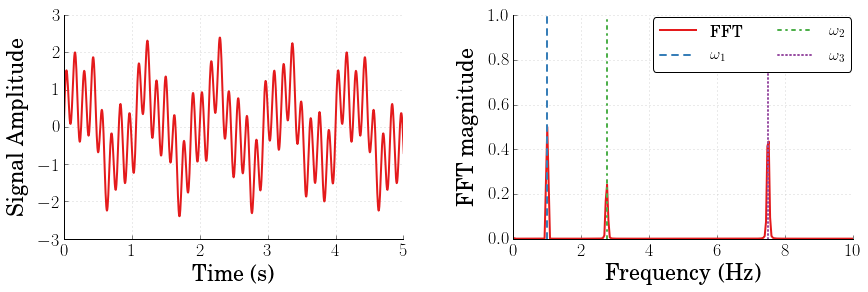

In [7]:
# Call the slider interaction
interact(plot_FFT, A1 = (0, 1, 0.1), 
                   f1 = (0, 10, 0.25), 
                   A2 = (0, 1, 0.1), 
                   f2 = (0, 10, 0.25), 
                   A3 = (0, 1, 0.1), 
                   f3 = (0, 10, 0.25))

If you'd like to explore the FFT further, the tutorials below and the links referenced within them have much more information:

* [Understanding the FFT Algorithm][0-3]
* [The Math Trick Behind MP3s, JPEGs, and Homer Simpson’s Face][0-4]
* [NI FFT Fundamentals][0-1]
* [SciPy Lectures Notes FFT][0-5]
* [Fourier transform for dummies][0-2]

[0-1]: http://zone.ni.com/reference/en-XX/help/372416B-01/svtconcepts/fft_funda/ "FFT Fundamentals (Sound and Vibration Measurement Suite) - Sound and Vibration Measurement Suite 7.0 Help - National Instruments"
[0-2]: http://nipunbatra.github.io/2016/01/fft/ "Fourier transform for dummies | Nipun Batra |"
[0-3]: http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/ "Understanding the FFT Algorithm"
[0-4]: http://nautil.us/blog/the-math-trick-behind-mp3s-jpegs-and-homer-simpsons-face "The Math Trick Behind MP3s, JPEGs, and Homer Simpson’s Face - Facts So Romantic - Nautilus"
[0-5]: http://www.scipy-lectures.org/intro/scipy.html#fast-fourier-transforms-scipy-fftpack "1.5. Scipy : high-level scientific computing — Scipy lecture notes"

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.


In [8]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(open(css_file, "r").read())